This notebook represents the online calibration experiment of the Lorenz 63 model using online learning with the Static-EGA method. 

In [22]:
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint as odeint_torch
from utils import reshape_dataset_to_torch, train_L63

In [23]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [24]:
# parameters of the training experiment
params = {'grad_mode': 'EGA-static','dim_state': 3, 'dim_output': 3, 'transition_layers': 2, 'dim_hidden_dyn_mdl': 3, 'train_size': 5000,
          'ntrain': 600, 'dt_integration': 0.01, 'pretrained': False, 'Batch_size': 32, 'seq_size': 10,
          'nb_part': 5, 'output_folder': 'output_models/',
          'model_save_file_name': 'L63_EGA-static.pt', 'device': 'cuda'}

The Lorenz 63 dynamical system is a 3-dimensional model of the form:
\begin{equation}
\begin{aligned}
    \dot{{u}}^{\dagger}_{t,1} &= \sigma({u}^{\dagger}_{t,2}-{u}^{\dagger}_{t,1})\\
    \dot{{u}}^{\dagger}_{t,2} &= \rho {u}^{\dagger}_{t,1} - {u}^{\dagger}_{t,2} - {u}^{\dagger}_{t,1}{u}^{\dagger}_{t,3}\\
    \dot{{u}}^{\dagger}_{t,3} &= {u}^{\dagger}_{t,1}{u}^{\dagger}_{t,2} - \beta{u}^{\dagger}_{t,3}
\end{aligned}
\end{equation}
Under parametrization $\sigma =10$, $\rho=28$ and  $\beta=8/3$, this system exhibits chaotic dynamics with a strange attractor.

We assume here that we are provided with $\mathrm{F}$, an imperfect version of the above Lorenz system that does not include the term $\beta{u}^{\dagger}_{t,3}$. This new model can not simulate the Lorenz 63 strange attractor and converges to an equilibrium point. We correct this physical core with a sub-model $\mathrm{M}_{\mathrm{\theta}}$ as follows:
\begin{equation}
\dot{\mathrm{u}}_t = \underbrace{\mathrm{F}(\mathrm{u}_t) + \mathrm{M}_{\mathrm{\theta}}(\mathrm{u}_t)}_{\text{Hybrid model}}
\end{equation}
where $\mathrm{u}_t = [{u}_{t,1},{u}_{t,2},{u}_{t,3}]^T$ and $\mathrm{F}: \mathbb{R}^3 \longrightarrow \mathbb{R}^3$ is given by:
\begin{equation}
\begin{aligned}
    F_1(\mathrm{u}_t) &= \sigma({u}_{t,2}-{u}_{t,1})\\
    F_2(\mathrm{u}_t) &= \rho {u}_{t,1} - {u}_{t,2} - {u}_{t,1}{u}_{t,3}\\
    F_3(\mathrm{u}_t) &= {u}_{t,1}{u}_{t,2}
\end{aligned}
\end{equation}
The sub-model $\mathrm{M}_{\mathrm{\theta}}$ is a fully connected neural network with parameters $\mathrm{\theta}$. The resulting hybrid system is solved in time using the dopri5 solver. 

In this notebook, we assume that the forward solver is not differentiable (notice the "with_torch.nograd()" when using grad_mode == 'EGA-static') and we solve the online learning problem using the static EGA approximation. 

In [25]:
class HybridMdl(torch.nn.Module):
    def __init__(self, params):
        super(HybridMdl, self).__init__()
        # params of the true L63 system
        self.sigma = GD.parameters.sigma
        self.rho = GD.parameters.rho
        self.beta = GD.parameters.beta

        # params of the neural network correction
        self.trans_layers = params['transition_layers']
        self.transLayers = torch.nn.ModuleList([torch.nn.Linear(params['dim_state'], params['dim_hidden_dyn_mdl'])])
        self.transLayers.extend([torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_hidden_dyn_mdl']) for i in
                                 range(1, params['transition_layers'])])
        self.out_transLayers = torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_state'])

    def closure(self, x):
        for i in range(self.trans_layers):
            x = torch.tanh(self.transLayers[i](x))
        x = self.out_transLayers(x)
        return x

    def dyn_net(self, t, inp, closure = True):
        grad = (torch.zeros((inp.size())).to(inp.device))
        grad[:, 0] = self.sigma * (inp[:, 1] - inp[:, 0])
        grad[:, 1] = inp[:, 0] * (self.rho - inp[:, 2]) - inp[:, 1]
        grad[:, 2] = inp[:, 0] * inp[:, 1]  # + self.beta*inp[:,2];
        if closure:
            return grad + self.closure(inp)
        else:
            return grad
    def model_dt(self, inp, dt, t0=0,
                grad_mode='exact'):  # flow of the ODE, assuming the flow is autonomous so t0 is always 0
        if grad_mode == 'exact':
            pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt).to(inp.device), method='dopri5')
            return pred[-1, :, :]
        elif grad_mode == 'EGA-static' or grad_mode == 'EGA-ST' or grad_mode == 'EGA-J':
            with torch.no_grad():
                # blackbox non diff solver, here an adaptive dopri solver
                pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt).to(inp.device), method='dopri5')
            # computational graph of the blackbox solver
            if grad_mode == 'EGA-static':
                output_p = dt * self.closure(inp.detach()) + inp
                output_p.data = pred.data[-1, :, :]
            elif grad_mode == 'EGA-ST':
                output_p = dt * self.closure(inp) + inp
                output_p.data = pred.data[-1, :, :]
            elif grad_mode == 'EGA-J':
                output_p = dt * self.dyn_net(t0+dt,inp) + inp
                output_p.data = pred.data[-1, :, :]                
            return output_p
    def forward(self,dt, n, x0, closure = True, grad_mode = 'exact'):
        pred = [x0]
        for i in range(n):
            pred.append(self.model_dt(pred[-1],dt, grad_mode = grad_mode))
        pred_seq = torch.stack(pred)
        return pred_seq

In [26]:
class GD:
    model = 'Lorenz_63'

    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0 / 3

    dt_integration = params['dt_integration']  # integration time
    nb_loop_data = 60.0

In [27]:
# run the data generation
dataset = generate_data(GD)

In [28]:
# reshaping dataset
X_train, Y_train, X_test, Y_test = reshape_dataset_to_torch(dataset, params['seq_size'], params['train_size'])
training_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=params['Batch_size'], shuffle=True,
                                         pin_memory=False),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=params['Batch_size'], shuffle=False, pin_memory=False),
}

In [29]:
hybrid_L63 = HybridMdl(params).to(params['device'])

In [30]:
optimizer_ft = torch.optim.Adam(hybrid_L63.parameters(), lr=0.01)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)
model_best_valid, model, loss_train, loss_val = train_L63(hybrid_L63, dataloaders, optimizer_ft, exp_lr_scheduler, device=params['device'], num_epochs=params['ntrain'], dt=params['dt_integration'], seq_size=params['seq_size'], grad_mode=params['grad_mode'])
torch.save(model.state_dict(), params['output_folder'] + params['model_save_file_name'])

Epoch 0/599
----------
train: loss: 1.457373
LR 0.01
val: loss: 1.281035
saving best model
Epoch 1/599
----------
train: loss: 1.194116
LR 0.01
val: loss: 1.053099
saving best model
Epoch 2/599
----------
train: loss: 0.983219
LR 0.01
val: loss: 0.864311
saving best model
Epoch 3/599
----------
train: loss: 0.807185
LR 0.01
val: loss: 0.709399
saving best model
Epoch 4/599
----------
train: loss: 0.663337
LR 0.01
val: loss: 0.583341
saving best model
Epoch 5/599
----------
train: loss: 0.547040
LR 0.01
val: loss: 0.482830
saving best model
Epoch 6/599
----------
train: loss: 0.453174
LR 0.01
val: loss: 0.403763
saving best model
Epoch 7/599
----------
train: loss: 0.381806
LR 0.01
val: loss: 0.343034
saving best model
Epoch 8/599
----------
train: loss: 0.326411
LR 0.01
val: loss: 0.297228
saving best model
Epoch 9/599
----------
train: loss: 0.284008
LR 0.01
val: loss: 0.263769
saving best model
Epoch 10/599
----------
train: loss: 0.249448
LR 0.01
val: loss: 0.212239
saving best mode

In [31]:
initial_condition_test = next(iter(dataloaders['val']))[0][:1,:]
with torch.no_grad():
    simulation_hybrid = hybrid_L63(0.01, 1000, initial_condition_test.to(params['device']))[:,0,:]
    simulation_init_sys = odeint_torch(
        lambda t, inp: hybrid_L63.dyn_net(t, inp, closure=False), 
        initial_condition_test.to(params['device']), 
        torch.arange(0, 10 + 0.000001, 0.01).to(params['device']), 
        method='dopri5'
    )[:,0,:]

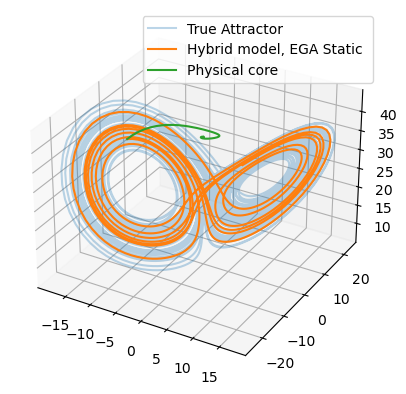

In [32]:
# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the line in 3D
ax.plot(dataset[:,0], dataset[:,1], dataset[:,2], label='True Attractor', alpha = 0.3)
ax.plot(simulation_hybrid.cpu().numpy()[:,0], simulation_hybrid.cpu().numpy()[:,1], simulation_hybrid.cpu().numpy()[:,2], label='Hybrid model, EGA Static ')
ax.plot(simulation_init_sys.cpu().numpy()[:,0], simulation_init_sys.cpu().numpy()[:,1], simulation_init_sys.cpu().numpy()[:,2], label='Physical core')
plt.legend()